<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #7: Clasificación y Agrupación
`Fecha de entrega: Octubre 24, 2020. (Antes del inicio de la próxima clase).`

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [1]:
import re
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
# Cargar datos
path = 'archivos/reviews_vidjew_es.csv'
data = pd.read_csv(path)
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


# Parte 1: Clasificación

### `[6 pts]` Punto 1: Dividir el conjunto de datos en entrenamiento y prueba

In [3]:
data.product_category.value_counts(normalize=True)

jewelry        0.502
video_games    0.498
Name: product_category, dtype: float64

In [4]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

print(f"El cojunto de datos de entrenamiento tiene {train.shape[0]} registros")
print(f"El cojunto de datos de prueba tiene {test.shape[0]} registros")

El cojunto de datos de entrenamiento tiene 800 registros
El cojunto de datos de prueba tiene 200 registros


###  `[6 pts]` Punto 2: Hacer pre-procesamiento del texto

In [5]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [6]:
X_train = tfidf_vect.fit_transform(train.review_body.values)
y_train = train.product_category.values

X_test = tfidf_vect.transform(test.review_body.values)
y_test = test.product_category.values

###  `[6 pts]` Punto 3: Entrenar el modelo
Puedes escoger el que quieras: Regresión Logística, Naive-Bayes, SVM, u otro.

In [23]:
# Inicializamos los clasificadores
logreg = LogisticRegression(class_weight="balanced")

# Entrenamos los modelos
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

###  `[6 pts]` Punto 4: Métricas de evaluación
Exactitud, precisión y sensibilidad

In [8]:
# Hacemos las predicciones para los datos de prueba (test)
y_pred_logreg = logreg.predict(X_test)

print(f"Exactitud: {accuracy_score(y_test, y_pred_logreg):.2f}")

metricas = [precision_score, recall_score, f1_score]

for metrica in metricas:
    print(f"{metrica.__name__}: {metrica(y_test, y_pred_logreg, pos_label='jewelry'):.2f}")

Exactitud: 0.86
precision_score: 0.86
recall_score: 0.86
f1_score: 0.86


###  `[BONUS: 3 pts]` Matriz de confusión

Text(0.5, 1.0, 'Regresión Logística')

<Figure size 1080x1080 with 0 Axes>

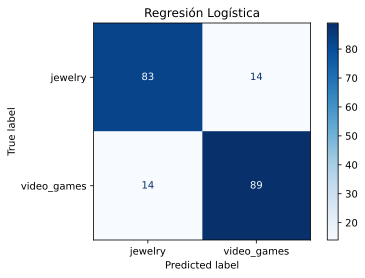

In [9]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize=(15,15))

plot_confusion_matrix(logreg, X_test, y_test, cmap = 'Blues')
plt.title("Regresión Logística")

###  `[BONUS: 1 pts]` Términos más importantes de cada categoría

In [10]:
vocab = {value:key for key, value in tfidf_vect.vocabulary_.items()}

In [11]:
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][-10:]

[('cable', 0.99),
 ('botones', 1.01),
 ('consola', 1.13),
 ('hijo', 1.18),
 ('funciona', 1.2),
 ('ps', 1.26),
 ('jugar', 1.36),
 ('perfecto', 1.36),
 ('mando', 1.94),
 ('juego', 3.61)]

In [12]:
[(vocab[e[0]],round(e[1],2)) for e in zip(logreg.coef_[0].argsort(),sorted(logreg.coef_[0]))][:10]

[('calidad', -1.96),
 ('foto', -1.94),
 ('pulsera', -1.87),
 ('bonito', -1.85),
 ('bonitos', -1.84),
 ('bonita', -1.55),
 ('plata', -1.53),
 ('cadena', -1.43),
 ('pequeño', -1.2),
 ('cierre', -1.16)]

# Parte 2: Agrupación

###  `[6 pts]` Punto 1: Hacer pre-procesamiento del texto

In [13]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect_kmeans = TfidfVectorizer(preprocessor=pre_procesado)
tfidf_kmeans = tfidf_vect_kmeans.fit_transform(data.review_body.values)
tfidf_matrix = pd.DataFrame(tfidf_kmeans.toarray(), columns=tfidf_vect_kmeans.get_feature_names())

###  `[6 pts]` Punto 2: Método del codo para determinar $K$

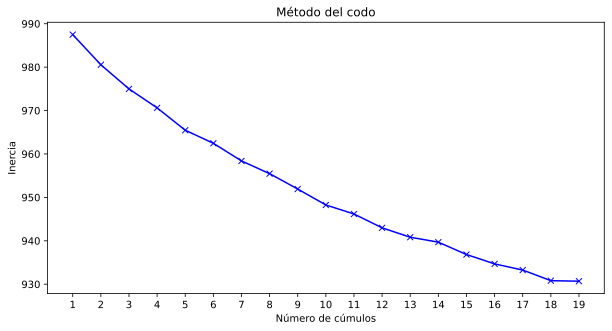

In [19]:
ks = []
kinertia = []

for k in range(1,20):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    ks.append(k)
    kinertia.append(kmeans.inertia_)
    
plt.figure(figsize=(10,5))
plt.xlabel("Número de cúmulos")
plt.ylabel("Inercia")
plt.title('Método del codo')
plt.xticks(ks)
plt.plot(ks,kinertia, 'bx-');

###  `[6 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [15]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [20]:
k = 5
model = KMeans(n_clusters=k)
model.fit(tfidf_matrix)
nbrs = NearestNeighbors(n_neighbors=3, metric='euclidean').fit(tfidf_matrix.values)

data['cluster'] = model.labels_
clust_cnt = data['cluster'].value_counts()
clust_cnt_pct = data['cluster'].value_counts(normalize=True)

print(f"{color.BOLD}CLUSTERS:\n{color.END}")
centroids = model.cluster_centers_
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect_kmeans.get_feature_names()

for i in range(k):
    print(f"{color.BLUE}Cluster {i}:{color.END}")
    print(f"{color.CYAN}COUNT {color.END} {clust_cnt[i]} comments ({clust_cnt_pct[i]:.2%} of the data)")
    print(f"{color.CYAN}TERMS {color.END}", end=" ")
    for ind in order_centroids[i, :20]:
        print(f'{color.BOLD}{terms[ind]}{color.END}', end=" "),
    print(f"\n{color.CYAN}REPRESENTATIVE COMMENTS{color.END}")
    for comment in data.iloc[nbrs.kneighbors([centroids[i]])[1][0]]['review_body'].values:
        print(f"* {comment}")
    print("\n")

CLUSTERS:

Cluster 0:
COUNT  104 comments (10.40% of the data)
TERMS  producto llegado perfecto buen precio todavía pedir gracias bueno rapido llego rápido puede sido día llegó puedo parece llega comprar 
REPRESENTATIVE COMMENTS
* El producto en buen estado. Perfecto.
* No ha llegado el collar . Las demás cosas que he comprado en Amazon han llegado, pero este producto no me ha llegado.
* No me a llegado todavía


Cluster 1:
COUNT  543 comments (54.30% of the data)
TERMS  bonito foto regalo si bonitos día mas mando precio mal mejor esperaba tamaño pequeños queda pulsera aunque plata pequeño bonita 
REPRESENTATIVE COMMENTS
* Bonito fue para un regalo y bien
* Me encantó es más bonito que en la foto
* Buscaba un collar para un regalo, y encontré este, con buen precio y bastante bonito y me ha sorprendido!! Llego bien en su embalaje sin ningun daño. El colgante se nota que es plata de ley y no ningun otro material chapado en plata, ademas en el cierre viene con uno de seguridad para que no

###  `[BONUS: 3 pts]` Visualización usando PCA

In [21]:
pca = PCA(n_components=2)

result = pca.fit_transform(tfidf_matrix)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = data.cluster.values
result['texto'] = data.review_body.apply(lambda val: val[:140])

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['cluster'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Parte 3: Comparación

### `[6 pts]` Punto 1: Hacer predicción para estas dos frases de los dos modelos

In [22]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
nuevo_trans = tfidf_vect.transform(test)
nuevo_trans_kmeans = tfidf_vect_kmeans.transform(test)

print(logreg.predict(nuevo_trans))
print(model.predict(nuevo_trans_kmeans))

['video_games' 'jewelry']
[3 4]


### `[2 pts]` Punto 2: Preguntas

- ¿A cuál modelo le fue mejor? 
- ¿Cuál modelo se demoró más en entrenar? 
- Según los resultados del $K$-Means, ¿cuál es la estructura latente de los datos?
- ¿Alguna otra observación?